<a href="https://colab.research.google.com/github/mike-ferguson/benford/blob/main/benford_verifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [112]:
# import or generate a dataset:

import pandas as pd, numpy as np
import random
import math 
from collections import Counter
from scipy import stats


# read in the dataset:
data = pd.read_csv('sales_data_sample.csv', encoding= 'unicode_escape')
print(data.columns)
col_wanted = "PRICEEACH"

# remove NA values or values not a number.
df = data[data[col_wanted].notna()]
df = df[pd.to_numeric(df[col_wanted], errors='coerce').notnull()]
df_final = df[col_wanted]

# casts entries to floats and make final list
numbers = list(df_final)
numbers = [float(i) for i in numbers]
numbers = [x for x in numbers if x > 0.0]

print(numbers)

Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')
[95.7, 81.35, 94.74, 83.26, 100.0, 96.66, 86.13, 100.0, 98.57, 100.0, 100.0, 100.0, 100.0, 100.0, 92.83, 100.0, 100.0, 100.0, 94.74, 100.0, 100.0, 72.55, 34.91, 76.36, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 99.91, 96.34, 100.0, 100.0, 100.0, 100.0, 100.0, 96.34, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 96.34, 100.0, 100.0, 100.0, 68.92, 51.15, 100.0, 44.51, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 1

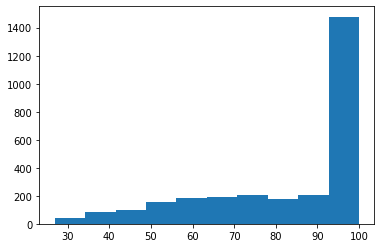

Mean:  83.65854410201914
Standard Deviation:  20.17427652784056
The mean is not greateer then the median. Your distribution might beoff; Benford's Law might not apply...


In [113]:
# look at the data to see properties, like normality:

from matplotlib import pyplot
import statistics

pyplot.hist(numbers)
pyplot.show()

mean = statistics.mean(numbers)
std = statistics.stdev(numbers)
median = statistics.median(numbers)
print("Mean: ", mean)
print("Standard Deviation: ", std)


# is mean greater then median?
if mean <= median:
  print("The mean is not greateer then the median. Your distribution might be" + 
        "off; Benford's Law might not apply...")


In [114]:
# process the raw list:
sig_list = ([x // (10**math.floor(math.log10(x))) for x in numbers])
print(sig_list[0:50])

# get Benford probabilities:
def benford (digit):
  return math.log10((digit + 1)/ digit)


[9.0, 8.0, 9.0, 8.0, 1.0, 9.0, 8.0, 1.0, 9.0, 1.0, 1.0, 1.0, 1.0, 1.0, 9.0, 1.0, 1.0, 1.0, 9.0, 1.0, 1.0, 7.0, 3.0, 7.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [115]:
# calculate meta-statistics:

actual_freqs = Counter(sig_list)
print(actual_freqs)

limit = len(numbers)
print(limit)

predicted = []
for i in range(1, 10):
  pred_num = benford(i) * limit
  predicted.append(round(pred_num, 4))

benford_list = [1,2,3,4,5,6,7,8,9]

predicted_freqs = dict(zip(benford_list, predicted))

df = pd.DataFrame({'Predicted Values':pd.Series(predicted_freqs),'Actual Values':pd.Series(actual_freqs)})


# df["Predicted Proportion"] = df['Predicted Values'] / limit
# df["Actual Proportion"] = df['Actual Values'] / limit

df["Predicted Percent"] = (df['Predicted Values'] / limit) * 100
df["Actual Percent"] = (df['Actual Values']  / limit) * 100


print(df)

actual_props = list(df["Predicted Percent"])
predicted_props = list(df["Actual Percent"])


Counter({1.0: 1304, 8.0: 287, 6.0: 275, 7.0: 265, 9.0: 230, 5.0: 210, 4.0: 150, 3.0: 91, 2.0: 11})
2823
     Predicted Values  Actual Values  Predicted Percent  Actual Percent
1.0          849.8077           1304          30.103000       46.191994
2.0          497.1056             11          17.609125        0.389656
3.0          352.7021             91          12.493875        3.223521
4.0          273.5770            150           9.691002        5.313496
5.0          223.5287            210           7.918126        7.438895
6.0          188.9908            275           6.694679        9.741410
7.0          163.7113            265           5.799196        9.387177
8.0          144.4036            287           5.115253       10.166490
9.0          129.1734            230           4.575749        8.147361


In [116]:
# create test statistic:
chi_squared = 0
for i in range(0,9):
  error = ((actual_props[i] - predicted_props[i]) ** 2) / predicted_props[i]
  chi_squared  = chi_squared + error

print(chi_squared)

803.2537652355268


In [117]:
# conduct actual hypthesis test:
# H0: All digits 1-9 Conform to the predicted Benford's Law Proportion
# H1: At least 1 digit does not conform to the predictions.


dof = 8

value = 1 - stats.chi2.cdf(chi_squared, dof)
print( "P value: " ,value)
print( "Alpha: " , 0.05)


if value < 0.05:
  print("Results are significant at this Alpha Level (0.05). \nThis indicates " + 
        "very strong evidence that Benford's Law is NOT obeyed. H0 is rejected.")
else:
  print("Results are not statistically significant. \nThis indicates " + 
        "very strong evidence that Benford's Law IS obeyed. Fail to reject H0.")

P value:  0.0
Alpha:  0.05
Results are significant at this Alpha Level (0.05). 
This indicates very strong evidence that Benford's Law is NOT obeyed. H0 is rejected.


**History of Data Tested so Far:**

-- Dataset | Column | Chi-Squre Value | p-Value | Result -- 

1) NYC Property Sales, SALE PRICE, 6.0326, 0.64357, **Obeys**

2) Video Game Sales, NA_Sales, 28.801, 0.00034, **Does not Obey**

3) Video Game Sales, EU_Sales, 66.899, 2.029E-11, **Does not Obey**

4) Video Game Sales, JP_Sales, 81.6581, 2.264E-14, **Does not Obey**

5) Sample Sales Data, SALES, 30.505, 1.721E-4, **Does not Obey**

6) Sample Sales Data, QUANTITYORDERED, 2999.20, 0.0, **Does not Obey**

6) Sample Sales Data, PRICEEACH, 803.25, 0.0, **Does not Obey**


**Links to Datasets:**

1) https://www.kaggle.com/new-york-city/nyc-property-sales

2, 3, 4) https://www.kaggle.com/gregorut/videogamesales

5, 6, 7) https://www.kaggle.com/kyanyoga/sample-sales-data
